In [13]:
import pandas as pd
import numpy as np
import re
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms

from sklearn.metrics import f1_score

from transformers import BertTokenizer, BertModel
from transformers import AutoModel, AutoTokenizer 

In [10]:
#def CleanText(text):
#    text = re.sub(r'''[\[|\]]''', "", text).split()
#    text = np.array(text, dtype="float64")
#    return text

In [62]:
def CleanText(text):
    text = text.lower() #Turn all text entries into lower-case
    text = re.sub(r'''(https?:\/\/www\.|https?:\/\/)?[a-z0-9]+([\-\.]{1}[a-z0-9]+)*\.[a-z]{2,3}[-a-zA-Z0-9()@:%_\+.~#?&\//=<>]*''', "<URL>", text)
    #Replace URL with tag
    text = re.sub(r'''[0-9]+[/\-.]+[0-9]+[/\-.]+[0-9]+''', "<DATE>", text) #Replace dates with tag
    text = re.sub(r'''[a-z0-9._%+-]+\@[a-z0-9.-]+[a-z0-9]\.[a-z]{1,}''', "<EMAIL>", text)
    #text = re.sub(r'''[0-9]+''', "<NUM>", text) #Replace numbers with tag
    text = re.sub(r'''[.|,|!|?|\'|\''|\"|\n|\t|\-|\(|\)]''', '', text)
    text = re.sub(r'''^\s+|\s+$''', '', text) #Remove whitespaces at the end and start of string
    text = re.sub(r'''[ ][ ]+|_''', " ", text) #Remove multiple whitespace
    if len(text) <= 0:
        text = re.sub(r'''''', "0", text) #Remove multiple whitespace
    return text

In [11]:
# Normal dataset
df = pd.read_csv("smallDomainDataNotEmbedded.csv")

# Epsilon 0,1 fair dataset
#df = pd.read_csv("domain_data_with_identities_private_xtrain0,1.csv")

# Epsilon 0,01 fair dataset
#df = pd.read_csv("domain_data_with_identities_private_xtrain0,1.csv")

#df['comment_text'] = df['comment_text'].apply(lambda text: CleanText(text))

In [12]:
# Updating values for training_data
training_data = df[df['split'] == 'train']
#training_data = training_data.drop(training_data.query('toxicity==0').sample(frac=.85).index)

# Getting test_data
test_data = df[df['split'] == 'test']

# Getting validation_data
validation_data = df[df['split'] == 'val']
#validation_data = validation_data.drop(validation_data.query('toxicity==0').sample(frac=.85).index)

In [5]:
print('Toxic samples training data: ', sum(training_data['toxicity']))
print('None-toxic samples training data: ', len(training_data['toxicity'])-sum(training_data['toxicity']))

print("\n")
print('Toxic samples validation data: ', sum(validation_data['toxicity']))
print('None-toxic samples validation data: ', len(validation_data['toxicity'])-sum(validation_data['toxicity']))

print("\n")
print('Toxic samples test data: ', sum(test_data['toxicity']))
print('None-toxic samples test data: ', len(test_data['toxicity'])-sum(test_data['toxicity']))

print("\n")

for col in training_data.columns[3:]:
    print(col + ": " + str(np.sum(training_data[col])))

Toxic samples training data:  710
None-toxic samples training data:  710


Toxic samples validation data:  360
None-toxic samples validation data:  360


Toxic samples test data:  360
None-toxic samples test data:  360


male: 322.0
female: 276.0
LGBTQ: 234.0
christian: 214.0
muslim: 236.0
other_religion: 20.0
black: 250.0
white: 370.0


In [11]:
training_data.query('male==1 and toxicity==0')

,comment_text,split,toxicity,male,female,LGBTQ,christian,muslim,other_religion,black,white
51,Are you meaning to relate the quote from PT to...,train,0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1504,This guy had no business interacting with this...,train,0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1517,"Yes, he is the poster child for white, heteros...",train,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1534,What's wrong with expecting the normal degree ...,train,0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1537,Thanks man. but This ain't a democracy brother...,train,0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2355,More like you can't stand a man of value and d...,train,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2356,good hombre....bad hombre....he was an illegal...,train,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2357,Kind of like how if a male is the main charact...,train,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2358,White men?\nWhat?\nAnd ignore shooters of othe...,train,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [81]:
currTrain = training_data['comment_text'].values.tolist()
currTest = test_data['comment_text'].values.tolist()
currVal = validation_data['comment_text'].values.tolist()

In [82]:
bertweet = AutoModel.from_pretrained("vinai/bertweet-base")
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)                     
bertweet.eval()

X_train = torch.zeros((1420, 768))

with torch.no_grad():
    for i in range(len(currTrain)):
        input_ids = torch.tensor([tokenizer.encode(currTrain[i])])
        masks = [1]*len(input_ids[0])
        masks = torch.tensor([masks])   
        outputs = model(masks, input_ids)
        X_train[i] = outputs[1][0]
        
    #for i in range(len(currTest)):
    #    inputs = tokenizer([currTest[i]], return_tensors="pt")
    #    inputs = inputs.to('cuda')
    #    outputs = model(**inputs)
    #    X_test.append(outputs[1])
    
    #for i in range(len(currVal)):
    #    inputs = tokenizer([currVal[i]], return_tensors="pt")
    #    inputs = inputs.to('cuda')
    #    outputs = model(**inputs)
    #    X_val.append(outputs[1])

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.
Token indices sequence length is longer than the specified maximum sequence length for this model (213 > 128). Running this sequence through the model will result in indexing errors


In [98]:
print(currTrain[0])
print(currTrain[1])

does this fool ever work for Canadians.  I can't even look at his face anymore.  Resentment runs high when it comes to this clown. how much did this cost taxpayers....so he could like a prince.  Where is the Ethics officer with the Aga khan investigation?  Seriously, how long does that take. He has for Islam but not for his taxpaying Canadians.  Strange.
Prove it Ms Khalid.  Launch the exact same motion but change out Islam and Islamophobia with Judaism and Anti-Semitism.  Or Christianity and Christopobia.  You are singling out your religion for protection from criticism.  We are not fooled by your lies.


In [25]:
len(currTrain)

1420

In [8]:
### Set parameters for the model
#torch.manual_seed(42) # set fixed random seed for reproducibility
batch_size = 32
epochs = 50000
lr = 0.00002

cuda = True # Set this if training on GPU
cuda = cuda and torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
print("Using "+repr(device))

Using device(type='cuda')


In [9]:
#transform = transforms.Compose([transforms.ToTensor()])

# Creating data loaders
#X_train = np.array(training_data['comment_text'].values.tolist())
Y_train = np.array(training_data['toxicity'].values.tolist())

#X_test = np.array(test_data['comment_text'].values.tolist())
Y_test = np.array(test_data['toxicity'].values.tolist())

#X_val = np.array(validation_data['comment_text'].values.tolist())
Y_val = np.array(validation_data['toxicity'].values.tolist())

print(len(X_train))
print(len(Y_train))

prepare_trainloader = []
for i in range(len(X_train)):
    prepare_trainloader.append([X_train[i], Y_train[i]])
    
prepare_testloader = []
for i in range(len(X_test)):
    prepare_testloader.append([X_test[i], Y_test[i]])
    
prepare_validloader = []
for i in range(len(X_val)):
    prepare_validloader.append([X_val[i], Y_val[i]])

train_loader = torch.utils.data.DataLoader(prepare_trainloader, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(prepare_validloader, batch_size=len(prepare_validloader), shuffle=False)
test_loader = torch.utils.data.DataLoader(prepare_testloader, batch_size=batch_size, shuffle=False)

1420
1420


In [12]:
def CheckAccuracy(predictions, labels):
        acc = 0.0
        for i in range(len(predictions)):
            if (predictions[i] == labels[i]):
                acc += 1
        return acc/len(predictions)

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Sequential(nn.Linear(768, 64), nn.ReLU(), nn.Dropout(p=0.8))
        self.fc2 = nn.Sequential(nn.Linear(64, 32), nn.ReLU())
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
        #self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [16]:
# Setting up model parameters
model = Net().to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr)
#optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
loss_function = nn.BCELoss()
#loss_function = nn.MSELoss()
#loss_function = nn.NLLLoss()

# Initialising early stopping criterias
early_stopping = 50
notImproved = 0
bestLoss = None
bestModel = None

trainArr = []
valArr = []

bestf1 = 0
bestEpoch = 0

for epoch in range(1, epochs + 1):
    
    train_loss = 0.0
    for batch_idx, data in enumerate(train_loader):
        
        # get the input
        inputs, labels = data
        
        inputs = inputs.unsqueeze(1)
        
        inputs = inputs.to(device).float()
        labels = labels.to(device).float()
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize            
        outputs = model(inputs).squeeze()
        
        
        loss = loss_function(outputs, labels)
        
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader.dataset)
    
    #if epoch % 10 == 0:
    #    print('====> Epoch: {} Average training loss: {:.6f}'.format(epoch, train_loss))
    
    trainArr.append(train_loss)
    
    valid_loss = 0
    labs = []
    preds = []
    
    model.eval()
    with torch.no_grad():        
        for batch_idx, data in enumerate(valid_loader):
            # get the input
            inputs, labels = data
            inputs = inputs.unsqueeze(1)
            inputs = inputs.to(device).float()
            #labels = labels.to(device).long()
            labels = labels.to(device).float()
            
            outputs = model(inputs).squeeze()
            
            labs.extend(labels)
            preds.extend(torch.round(outputs))
            #preds.extend(outputs.argmax(axis=1))
            
            valid_loss += loss_function(outputs, labels).item()
    
    valid_loss /= len(valid_loader.dataset)
    
    valArr.append(valid_loss)
    
    #if epoch % 10 == 0:
        #print('====> Validation set loss: {:.6f}'.format(valid_loss))
    
        #print("Accuracy on Validation set: ", CheckAccuracy(labs, preds))
    
    f1 = f1_score(torch.Tensor(labs).numpy(), torch.Tensor(preds).numpy(), zero_division=1)
    print("F1_score: ", f1)
    
    if f1 > bestf1:
        bestModel = model
        bestf1 = f1
        notImproved = 0
        bestEpoch = epoch
    else:
        notImproved +=1
        
    if notImproved >= early_stopping:
        break
        
    
    # Initialising params for early stopping
    #if bestLoss == None:
    #    bestLoss = valid_loss
        
    # Checks for early stopping
    #if f1 < bestf1:
    #    bestLoss = valid_loss
        
    # Converges if the training has not improved for a certain amount of iterations
    

model = bestModel

print(bestEpoch)

#torch.save(model, 'bestModelFullyConnectedNetwork0,1Fair.pth')

F1_score:  0.0
F1_score:  0.0
F1_score:  0.0
F1_score:  0.0
F1_score:  0.0
F1_score:  0.0
F1_score:  0.0
F1_score:  0.0
F1_score:  0.0
F1_score:  0.027100271002710025
F1_score:  0.07253886010362695
F1_score:  0.00554016620498615
F1_score:  0.1497584541062802
F1_score:  0.18433179723502302
F1_score:  0.16783216783216787
F1_score:  0.25684210526315787
F1_score:  0.19730941704035876
F1_score:  0.379182156133829
F1_score:  0.2803347280334728
F1_score:  0.344294003868472
F1_score:  0.43434343434343436
F1_score:  0.3260437375745527
F1_score:  0.4669887278582931
F1_score:  0.4853168469860896
F1_score:  0.3619047619047619
F1_score:  0.5030120481927711
F1_score:  0.483619344773791
F1_score:  0.4827586206896552
F1_score:  0.49319213313161875
F1_score:  0.46984126984126984
F1_score:  0.5065885797950219
F1_score:  0.5176803394625177
F1_score:  0.5276243093922652
F1_score:  0.5222381635581061
F1_score:  0.523121387283237
F1_score:  0.510385756676558
F1_score:  0.4615384615384615
F1_score:  0.527817

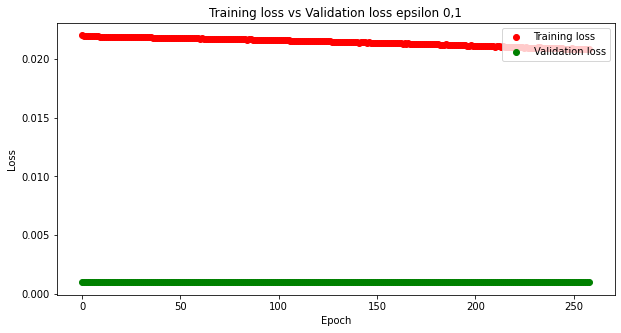

In [17]:
plt.figure(figsize=(10,5))
plt.scatter(np.arange(0,len(trainArr)), trainArr, color='r', label='Training loss')
plt.scatter(np.arange(0,len(valArr)), valArr, color='g', label='Validation loss')
plt.title("Training loss vs Validation loss epsilon 0,1")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

In [18]:
def F1_Scores(preds, labels):
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    for i in range(len(labs)):
        if labels[i]==1 and preds[i]==1:
            true_positives += 1
        if labels[i]==0 and preds[i]==0:
            true_negatives += 1
        if labels[i]==0 and preds[i]==1:
            false_positives += 1
        if labels[i]==1 and preds[i]==0:
            false_negatives += 1
    print("true_positives", true_positives)
    print("true_negatives", true_negatives)
    print("false_positives", false_positives)
    print("false_negatives", false_negatives)
    
    return true_positives, true_negatives, false_positives, false_negatives

In [19]:
labs = []
preds = []

model.eval()
with torch.no_grad():        
    for batch_idx, data in enumerate(test_loader):
        # get the input
        inputs, labels = data
        inputs = inputs.unsqueeze(1)
        inputs = inputs.to(device).float()
        labels = labels.to(device).float()
        
        outputs = model(inputs).squeeze()
        
        labs.extend(labels)
        preds.extend(torch.round(outputs))
        
print("Accuracy on test set: ", CheckAccuracy(labs, preds))


model.eval()
with torch.no_grad():        
    for batch_idx, data in enumerate(valid_loader):
        # get the input
        inputs, labels = data
        inputs = inputs.unsqueeze(1)
        inputs = inputs.to(device).float()
        labels = labels.to(device).float()
        
        outputs = model(inputs).squeeze()
        
        labs.extend(labels)
        preds.extend(torch.round(outputs))
        
print("Accuracy on validation set: ", CheckAccuracy(labs, preds))

model.eval()
with torch.no_grad():        
    for batch_idx, data in enumerate(train_loader):
        # get the input
        inputs, labels = data
        inputs = inputs.unsqueeze(1)
        inputs = inputs.to(device).float()
        labels = labels.to(device).float()
        
        outputs = model(inputs).squeeze()
        
        labs.extend(labels)
        preds.extend(torch.round(outputs))
        
print("Accuracy on train set: ", CheckAccuracy(labs, preds))

f1 = f1_score(torch.Tensor(labs).numpy(), torch.Tensor(preds).numpy(), zero_division=1)
print("F1_score: ", f1)

true_positives, true_negatives, false_positives, false_negatives = F1_Scores(preds, labs)

#print("Toxic accuracy: ", true_positives/5640)
#print("Non-toxic accuracy: ", true_negatives/42235)

Accuracy on test set:  0.5680555555555555
Accuracy on validation set:  0.5513888888888889
Accuracy on train set:  0.5786713286713286
F1_score:  0.5725434551259312
true_positives 807
true_negatives 848
false_positives 582
false_negatives 623


1430

In [191]:
from diffprivlib.models import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support

epsilons = [0.0001, 0.001, 0.01, 0.1, 1, 10, 30, 40, 50, 60, 70, 80, 90, 1000]



for eps in epsilons:
    print(eps)
    clf = LogisticRegression(epsilon=eps)
    clf.fit(X_train, Y_train)
    predictions = clf.predict(X_test)
    f1 = f1_score(predictions, Y_test, zero_division=1)
    
    print("F1_score: ", f1)
    
    print(clf.score(X_test, Y_test))
    print("\n")
    
    #F1_Scores(predictions, Y_test)

#predictions = np.array(predictions).reshape(len(predictions), 1)
#Y_test = np.array(Y_test).reshape(len(Y_test), 1)

    

0.0001
F1_score:  0.29494949494949496
0.5152777777777777


0.001
F1_score:  0.6327568667344863
0.4986111111111111


0.01
F1_score:  0.1763341067285383
0.5069444444444444


0.1
F1_score:  0.431496062992126
0.4986111111111111


1
F1_score:  0.5142857142857143
0.5041666666666667


10
F1_score:  0.5066666666666667
0.5375


30


C:\Users\frede\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\frede\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\frede\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLea

F1_score:  0.5127516778523491
0.49583333333333335


40
F1_score:  0.529960053262317
0.5097222222222222


50


C:\Users\frede\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\frede\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\frede\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no addi

F1_score:  0.5097493036211698
0.5111111111111111


60
F1_score:  0.5623268698060941
0.5611111111111111


70


C:\Users\frede\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\frede\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\frede\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no addi

F1_score:  0.5058139534883721
0.5277777777777778


80
F1_score:  0.5314285714285715
0.5444444444444444


90


C:\Users\frede\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\frede\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\frede\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no addi

F1_score:  0.5244565217391304
0.5138888888888888


1000
F1_score:  0.5439330543933054
0.5458333333333333




C:\Users\frede\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
C:\Users\frede\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:221: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
C:\Users\frede\anaconda3\lib\site-packages\diffprivlib\models\logistic_regression.py:394: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
